In [62]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools


#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima   
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import os, sys
# path_add = os.path.abspath(os.pardir)
# if path_add not in sys.path:
#     sys.path.append(path_add)

%matplotlib inline

In [2]:
r = pd.read_csv('data/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv')

In [3]:
r.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
0,102001,0,United States,Country,NaN,106953.0,106985.0,107040.0,107176.0,107328.0,...,250423.0,251694.0,253237.0,255210.0,257515.0,260052.0,262812.0,265679.0,268580.0,271648.0
1,394913,1,"New York, NY",Msa,NY,191361.0,190915.0,190632.0,190084.0,189750.0,...,485686.0,487729.0,490510.0,494070.0,498728.0,503895.0,509538.0,514975.0,520272.0,525653.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,194612.0,194916.0,194951.0,195099.0,195102.0,...,734681.0,736171.0,740996.0,748828.0,757141.0,764656.0,772236.0,779988.0,787220.0,794492.0
3,394463,3,"Chicago, IL",Msa,IL,167216.0,166905.0,166494.0,166025.0,165397.0,...,251595.0,252283.0,253491.0,255114.0,257299.0,259748.0,262200.0,264627.0,266754.0,269462.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,112668.0,112739.0,112901.0,113219.0,113561.0,...,260130.0,261480.0,263069.0,264906.0,266809.0,269296.0,271846.0,274760.0,277118.0,280223.0


In [6]:
r = r[r['RegionName'] == 'Richmond, VA']

In [7]:
r.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
45,395022,45,"Richmond, VA",Msa,VA,111613.0,111598.0,111631.0,111665.0,111839.0,...,254888.0,256257.0,257697.0,259110.0,260847.0,262787.0,265345.0,268157.0,271127.0,273779.0


In [11]:
r = r.iloc[:,5:].transpose()

In [12]:
r.head()

,45
1996-01-31,111613.0
1996-02-29,111598.0
1996-03-31,111631.0
1996-04-30,111665.0
1996-05-31,111839.0


In [19]:
r.index = pd.to_datetime(r.index)

In [24]:
r.index[0].month

1

In [31]:
r.rename(columns = {45 : 'Zillow Home Value Index (ZHVI)'}, inplace = True )

In [32]:
r.head()

,Zillow Home Value Index (ZHVI)
1996-01-31,111613.0
1996-02-29,111598.0
1996-03-31,111631.0
1996-04-30,111665.0
1996-05-31,111839.0


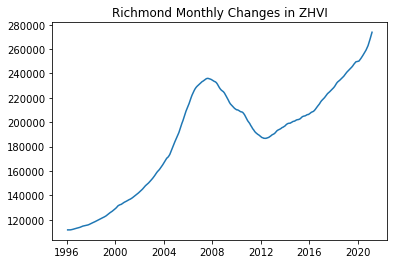

In [33]:
fig, ax = plt.subplots()
ax.plot(r)
ax.set_title("Richmond Monthly Changes in ZHVI");

In [37]:
#cutoff 20% of data
cutoff = round(r.shape[0]*0.8)
cutoff

242

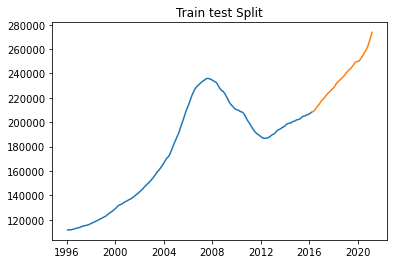

In [38]:
# Define train and test sets according to the index found above
train = r[:cutoff]
test = r[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

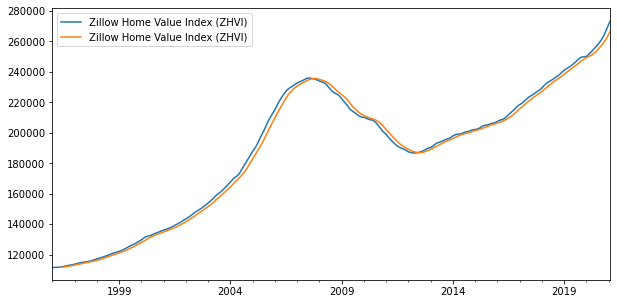

In [40]:
r_rolling = r.rolling(6).mean()

fig, ax = plt.subplots(figsize=(10, 5))

r.plot(ax=ax, label='raw')
r_rolling.plot(ax=ax, label='rolling average')

plt.legend();

<Figure size 432x288 with 0 Axes>

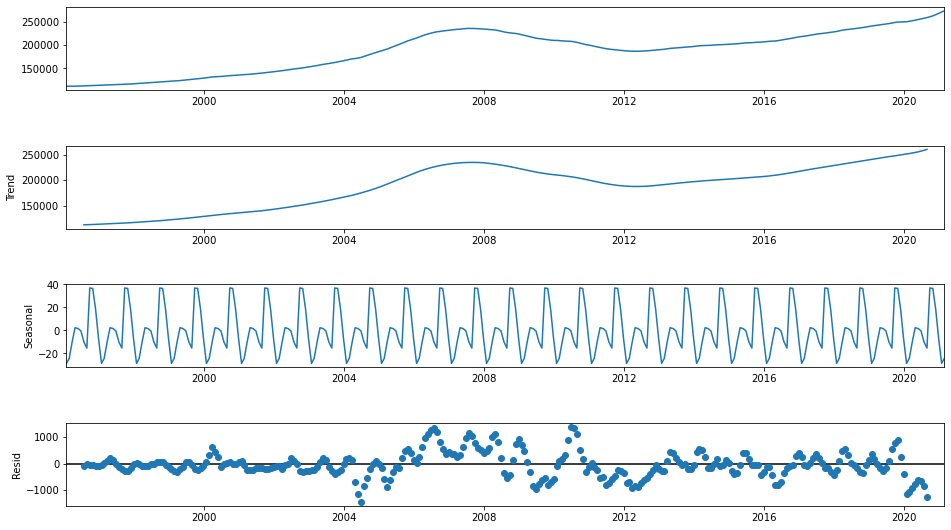

In [44]:
decomposition = seasonal_decompose(r)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

In [45]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', '#Lags Used',
                                             'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)

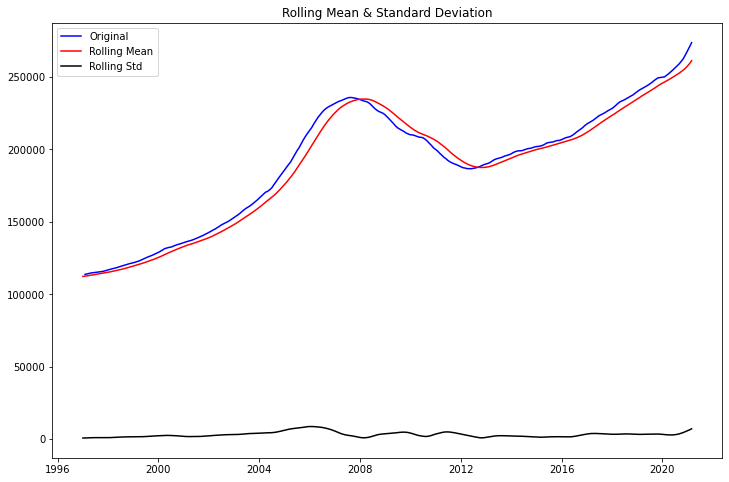

Results of Dickey-Fuller Test:
Test Statistic                  -0.479571
p-value                          0.895942
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [48]:
test_stationarity(r, 12)

In [53]:
r_diff = r.diff().dropna()

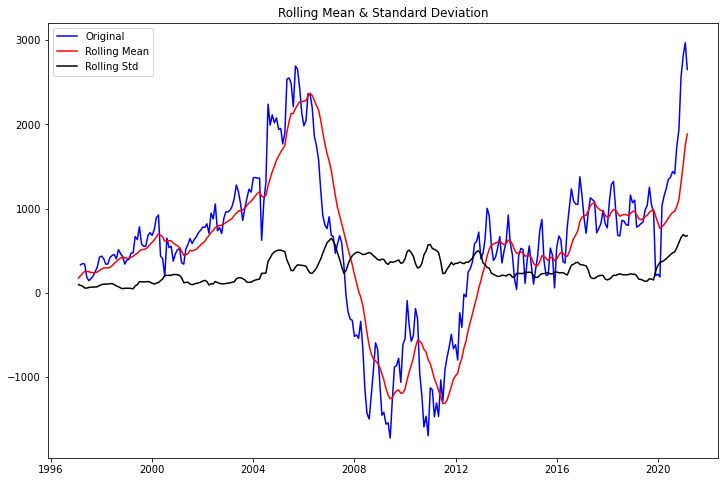

Results of Dickey-Fuller Test:
Test Statistic                  -1.643354
p-value                          0.460509
#Lags Used                      16.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [54]:
test_stationarity(r_diff, 12)

In [57]:
r_diff.head()

,Zillow Home Value Index (ZHVI)
1996-02-29,-15.0
1996-03-31,33.0
1996-04-30,34.0
1996-05-31,174.0
1996-06-30,208.0


In [58]:
r_diff2 = r.diff().diff().dropna()

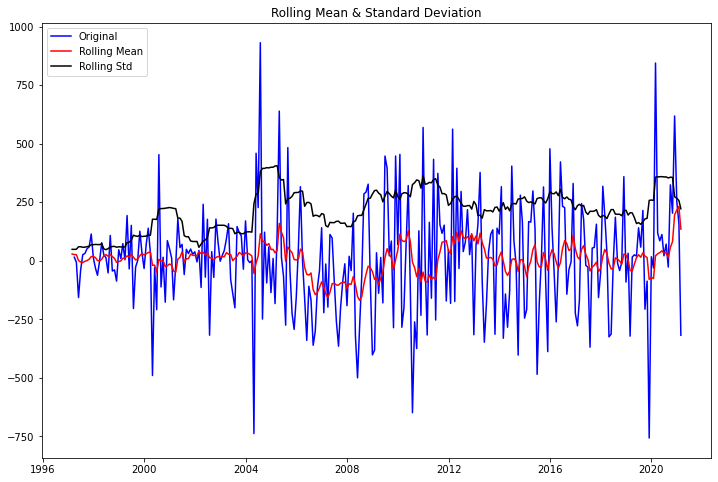

Results of Dickey-Fuller Test:
Test Statistic                  -3.419944
p-value                          0.010297
#Lags Used                      15.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


In [59]:
test_stationarity(r_diff2, 12)

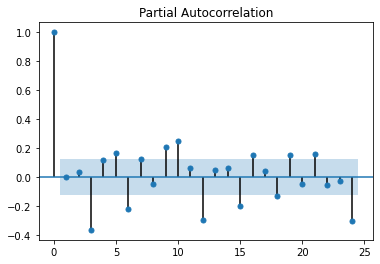

In [60]:
plot_pacf(train.diff().diff().dropna());

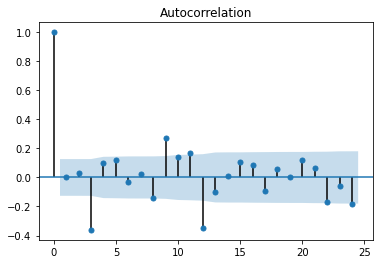

In [61]:
plot_acf(train.diff().diff().dropna());

In [96]:
auto_arima(r)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [98]:
auto_arima(r).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  302
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2393.340
Date:                Mon, 19 Apr 2021   AIC                           4794.681
Time:                        11:07:09   BIC                           4809.509
Sample:                             0   HQIC                          4800.615
                                - 302                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.6717      5.958      4.141      0.000      12.994      36.350
ar.L1          0.9300      0.009    108.635      0.000       0.913       0.947
ma.L1         -0.8244      0.012    -70.116      0.000      -0.847      -0.801
sigma2      2.033e+05   1.31e+04     15.564      0.000    1.78e+05    2.29e+05
===================================================================================
Ljung-Box (Q):                     1189.49   Jarque-Bera (JB):               483.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -1.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
train

,Zillow Home Value Index (ZHVI)
1996-01-31,111613.0
1996-02-29,111598.0
1996-03-31,111631.0
1996-04-30,111665.0
1996-05-31,111839.0
...,...
2015-10-31,206214.0
2015-11-30,206272.0
2015-12-31,206808.0
2016-01-31,207482.0


In [94]:
train.diff().diff().dropna()

,Zillow Home Value Index (ZHVI)
1996-03-31,48.0
1996-04-30,1.0
1996-05-31,140.0
1996-06-30,34.0
1996-07-31,57.0
...,...
2015-10-31,-85.0
2015-11-30,-388.0
2015-12-31,478.0
2016-01-31,138.0


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


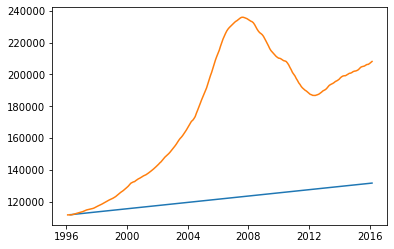

In [119]:
model = ARIMA(train, order=(1, 2, 1), freq = 'M').fit()
y_hat_train = model.predict(start=train.index[2], end=train.index[-1],typ='levels', dynamic = True)

fig, ax = plt.subplots()
ax.plot(y_hat_train)
ax.plot(train);

In [110]:
model.aic

3835.025525582875

In [111]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     Zillow Home Value Index (ZHVI)   No. Observations:                  242
Model:                             ARIMA(1, 1, 1)   Log Likelihood               -1914.513
Date:                            Mon, 19 Apr 2021   AIC                           3835.026
Time:                                    11:10:21   BIC                           3845.480
Sample:                                01-31-1996   HQIC                          3839.237
                                     - 02-29-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9414      0.007    136.947      0.000       0.928       0.955
ma.L1         -0.8309      0.010    -79.308      0.000      -0.851      -0.810
sigma2      1.617e+05   1.23e+04     13.119      0.000    1.38e+05    1.86e+05
===================================================================================
Ljung-Box (Q):                     1009.50   Jarque-Bera (JB):               295.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
y_hat_train

1996-03-31    111583.0
1996-04-30    111568.0
1996-05-31    111553.0
1996-06-30    111538.0
1996-07-31    111523.0
                ...   
2015-10-31    108058.0
2015-11-30    108043.0
2015-12-31    108028.0
2016-01-31    108013.0
2016-02-29    107998.0
Freq: M, Length: 240, dtype: float64